In [36]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import plotting
plt.style.use(plotting.blueprint)
from IPython.display import display
from ipywidgets import interact
import scipy.spatial

# Stochastic processes

A stochastic process is a process in which each step is made at random.

A good example of a behaviour in physics which is described by a stochastic process is Brownian Motion.
In Brownian motion the fast-moving particles in a fluid, which are travelling with momentum with both a random direction and magnitude collide with a test particle. 
As a result the test particle moves on a random path through the fluid.

Another important stochastic process in physics is nuclear decay, where at any given time there is a probability that an unstable atomic nucleus may or may not decay, and whether it does decay is random.

The simplest stochastic processes are random walks, where the size of each step is determined by drawing a number from a probability distribution, such as a normal distribution. 
We can make many steps to build-up a "walk" or "chain" of steps.

In [4]:
def random_walk(mean = 0, stdev = 1, iterations = 100, realisations=1):
    return np.cumsum(np.random.normal(mean, stdev, (realisations, iterations)), axis=1)

In [34]:
def plot_random_walk(mean, std):
    with plt.style.context(plotting.blueprint):
        f, ax = plt.subplots(1,1)
        ax.plot(random_walk(realisations=10, mean=mean, stdev=std).T, alpha=0.5);
        ax.set_title("Gaussian random walks")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Value")

By adjusting the standard deviation of the walk the size of steps can be altered: the larger the standard deviation the bigger the steps are likely to be.
We could also change the mean to a value which isn't zero. 
You can experiment with each of these effects using the sliders on the next cell.

In [35]:
interact(plot_random_walk, 
         mean=widgets.FloatSlider(min=0., max=3),
         std=widgets.FloatSlider(min=0.1, max=3), 
        continuous_update=False);

interactive(children=(FloatSlider(value=0.0, description='mean', max=3.0), FloatSlider(value=0.1, description=…

A random walk like this, which has jumps which are determined by drawing from a normal distribution is also known as a *Wiener Process*, and this is the model used to model Brownian motion.

If we consider the iterations to happen continuously over time then the change in the value, $\Delta d$, of the process over a time $\Delta t$ will be 
\\[ \Delta d \sim \mathcal{N}(0, \Delta t) \\]
so the value $d(t)$ at a time $t$ will be $d(t + \Delta t) = d(t) + \Delta d

Each time the stochastic process runs it will take a different path , and each path is known as a "realisation" of the process, or a "sample" from the process.
Each of these samples also associates a value with every step, $t$, of the process, and so each sample is a function of $t$.
As a result stochastic processes can be treated as random distributions over functions (compared to probability distributions, which are [normally] random distributions over scalars).

# Gaussian processes

In the Wiener process introduced in the previous section the size of a random step is determined only by the length of time which the step takes.

What if we want to make a more complicated requirement on the data, so that the next step is determined by all of the previous steps? 

When we do this we get a Gaussian process, and the way in which steps must relate to the previous steps are determined by *covariance functions*.

In [39]:
def exp_q(x, y, length=1):
    """The squared-exponential covariance function"""
    distances = scipy.spatial.distance.cdist(np.expand_dims(x, 1), np.expand_dims(y, 1), "sqeuclidean")
    return np.exp(-0.5 * 1./length * distances)

In [50]:
def exp(x, y, length=1):
    """The squared-exponential covariance function"""
    distances = scipy.spatial.distance.cdist(np.expand_dims(x, 1), np.expand_dims(y, 1), "euclidean")
    return np.exp(1./length * (distances))

In [57]:
def periodic(x, y, length=1, period=1):
    """The squared-exponential covariance function"""
    distances = scipy.spatial.distance.cdist(np.expand_dims(x, 1), np.expand_dims(y, 1), "sqeuclidean")
    return np.exp(- (2*np.sin(np.pi*np.sqrt(distances)/period)**2) / length**2)

In [61]:
def localperiodic(x, y, length1=1, length2=1, period=1):
    """The squared-exponential covariance function"""
    return(exp_q(x,y, length1) * periodic(x, y, length2, period))

In [43]:
x = np.linspace(-20, 20, 300)
K = exp_q(x,x, length=1)

In [44]:
def gp_prior(x, covariance_function, realisations=1, **covariance_pars):
    K = covariance_function(x,x, **covariance_pars)
    return np.array([np.random.multivariate_normal(mean = 0.4*np.ones(K.shape[0]), cov=K) for i in range(realisations)])

In [45]:
stepState = 0
def gp_prior_samples(x, covariance_function, realisations=1, alpha=0.2, **covariance_pars):
    K = covariance_function(x,x, **covariance_pars)
    
    alpha = 1-alpha
    p = []
    z = []
    
    steps = realisations
    for step in range(steps):
        if step == 0:
            initial = np.random.multivariate_normal(mean = 0.4*np.ones(K.shape[0]), cov=K)
            z.append(initial)
            p.append(initial)
        if step % 50 == 0:
            z.append(p[-1])
            
            new_state = alpha*p[-1] + (np.sqrt(1-alpha**2) * np.random.multivariate_normal(mean = 0.4*np.ones(K.shape[0]), cov=K))
            
            p.append(new_state)
        else:
            a = p[-1]
            b = z[-1] 
            c = -1 * z[-1]
            d = p[-1]
            
            z.append((a * np.sin(0.1)) + (b * np.cos(0.1)))
            #outs.append(alpha * outs[-1] + np.sqrt(1-alpha**2) * np.random.multivariate_normal(mean = 0.4*np.ones(K.shape[0]), cov=K))
            p.append((c * np.sin(0.1)) + (d*np.cos(0.1)))

    return np.array(p)

In [46]:
ax.axes.spines["left"]

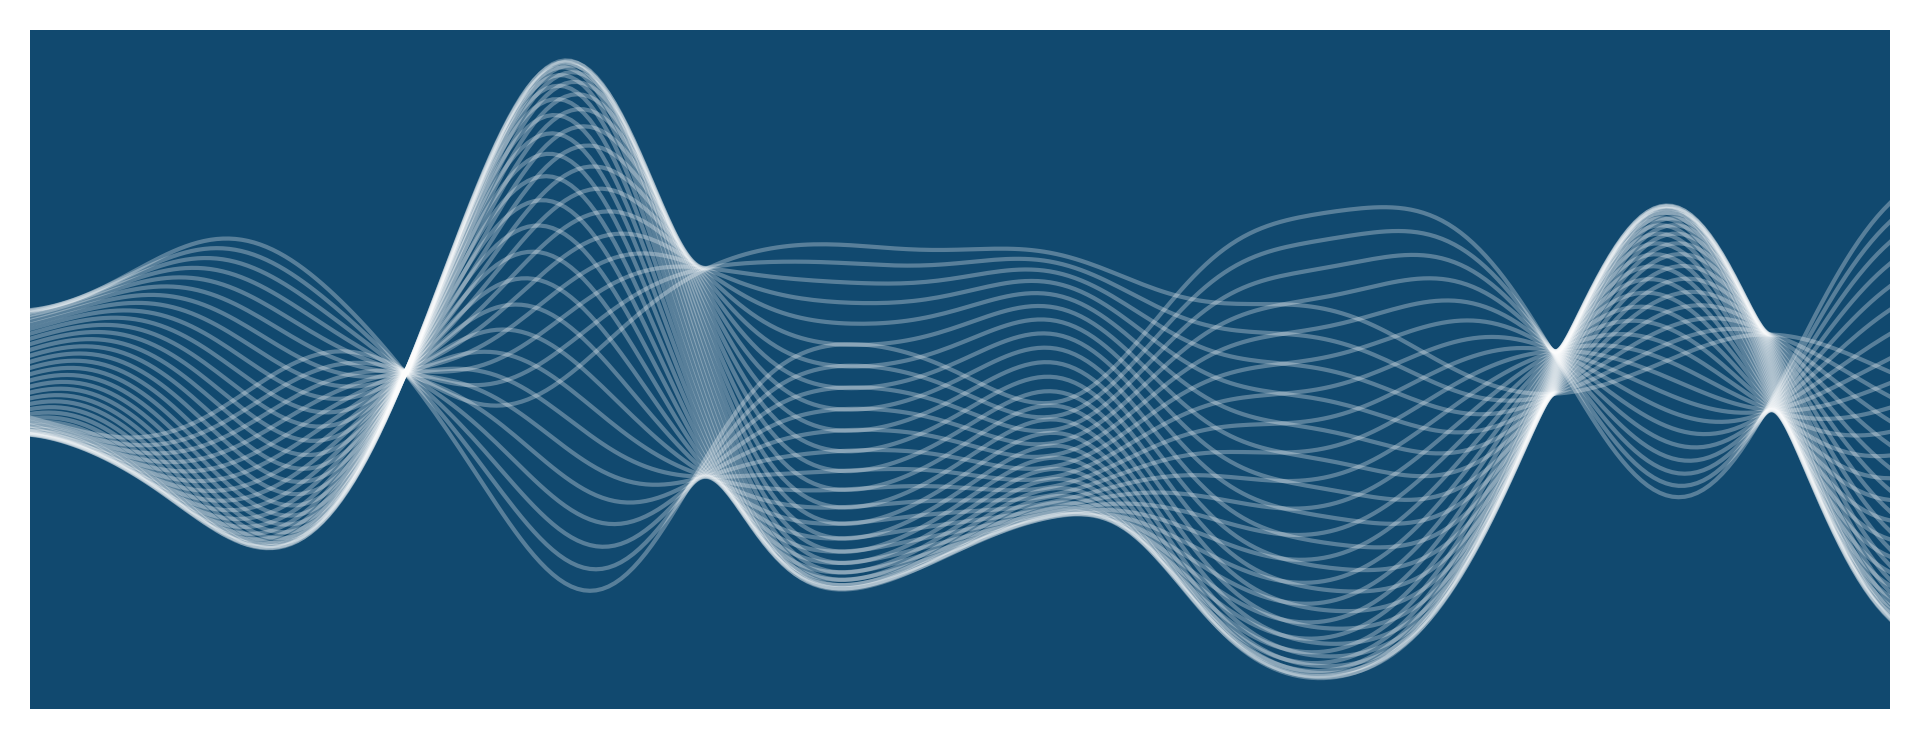

In [47]:
f, ax = plt.subplots(1,1, figsize=(8,3), dpi=300)

ax.plot(x, gp_prior_samples(x, exp_q, realisations=40, length=9.5).T[:,1:], color='w', lw =1, alpha=0.3);
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-20,20]);
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
f.savefig("../gpr-cover.png")

/home/daniel/.pyenv/versions/3.7.4/envs/teaching-stats/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: covariance is not positive-semidefinite.
  if sys.path[0] == '':
/home/daniel/.pyenv/versions/3.7.4/envs/teaching-stats/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: covariance is not positive-semidefinite.


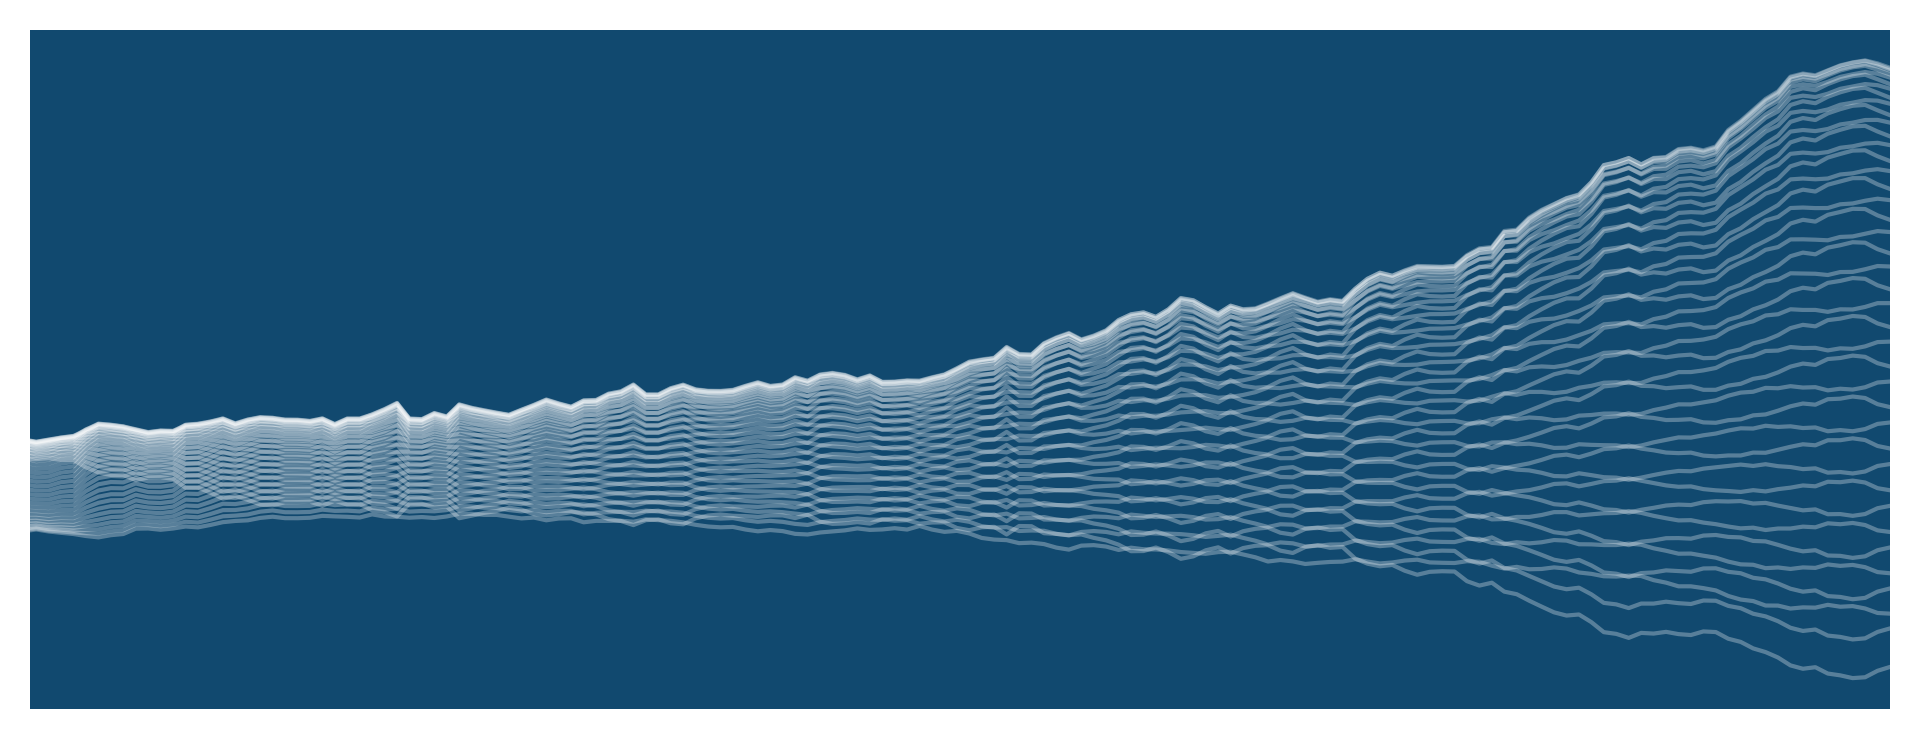

In [52]:
f, ax = plt.subplots(1,1, figsize=(8,3), dpi=300)

ax.plot(x, gp_prior_samples(x, exp, realisations=40, length=9.5).T[:,1:], color='w', lw =1, alpha=0.3);
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-0,20]);
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)

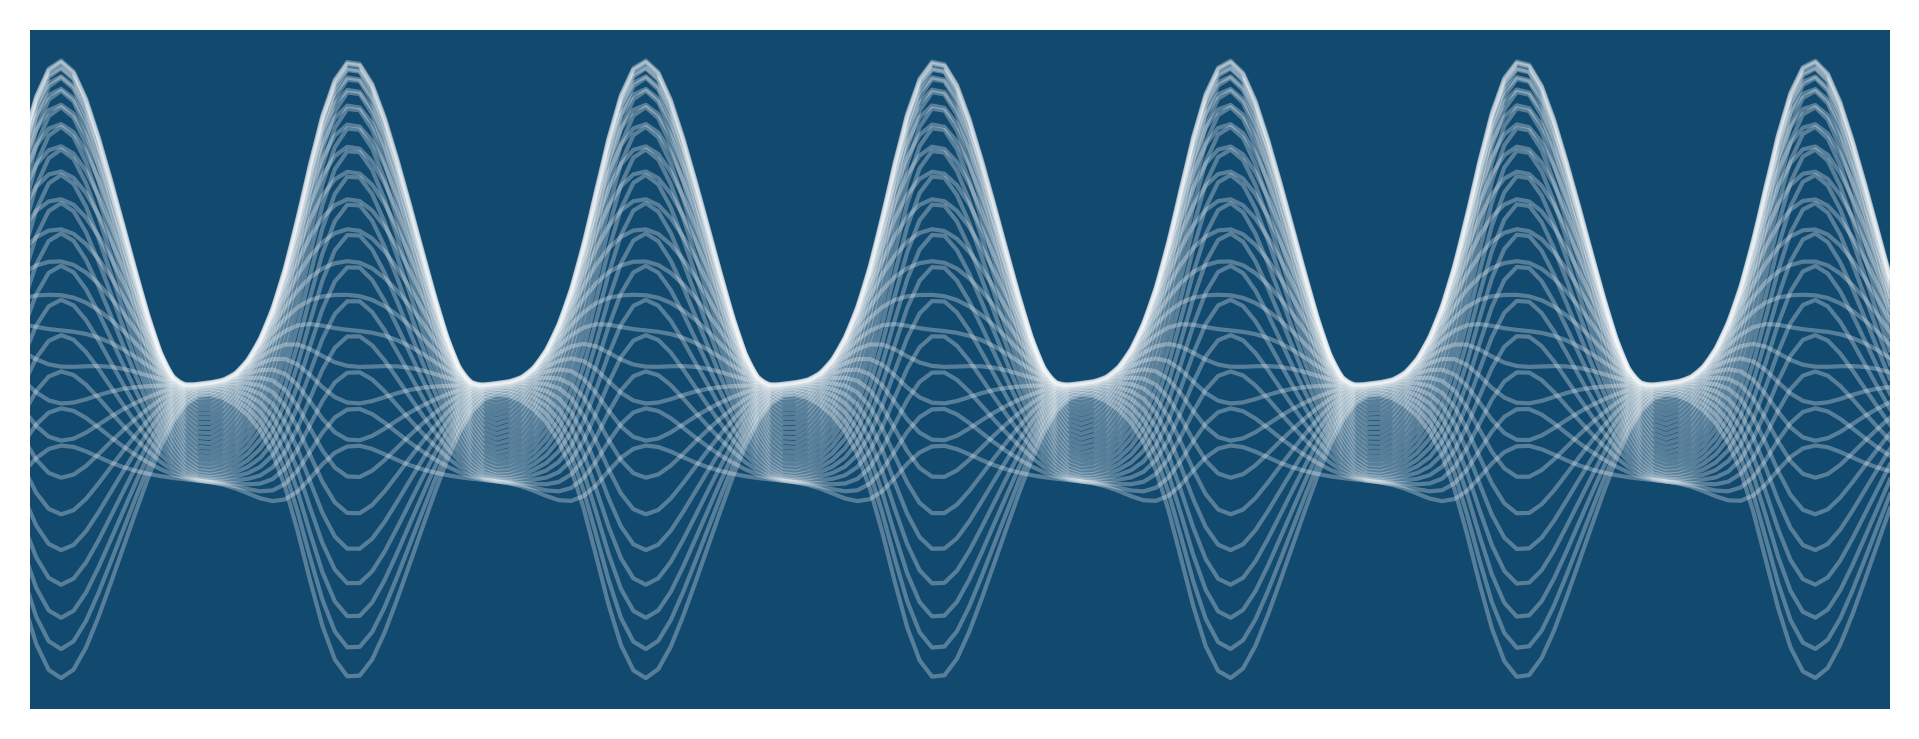

In [60]:
f, ax = plt.subplots(1,1, figsize=(8,3), dpi=300)

ax.plot(x, gp_prior_samples(x, periodic, realisations=40, length=1.5, period=np.pi).T[:,1:], color='w', lw =1, alpha=0.3);
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-0,20]);
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)

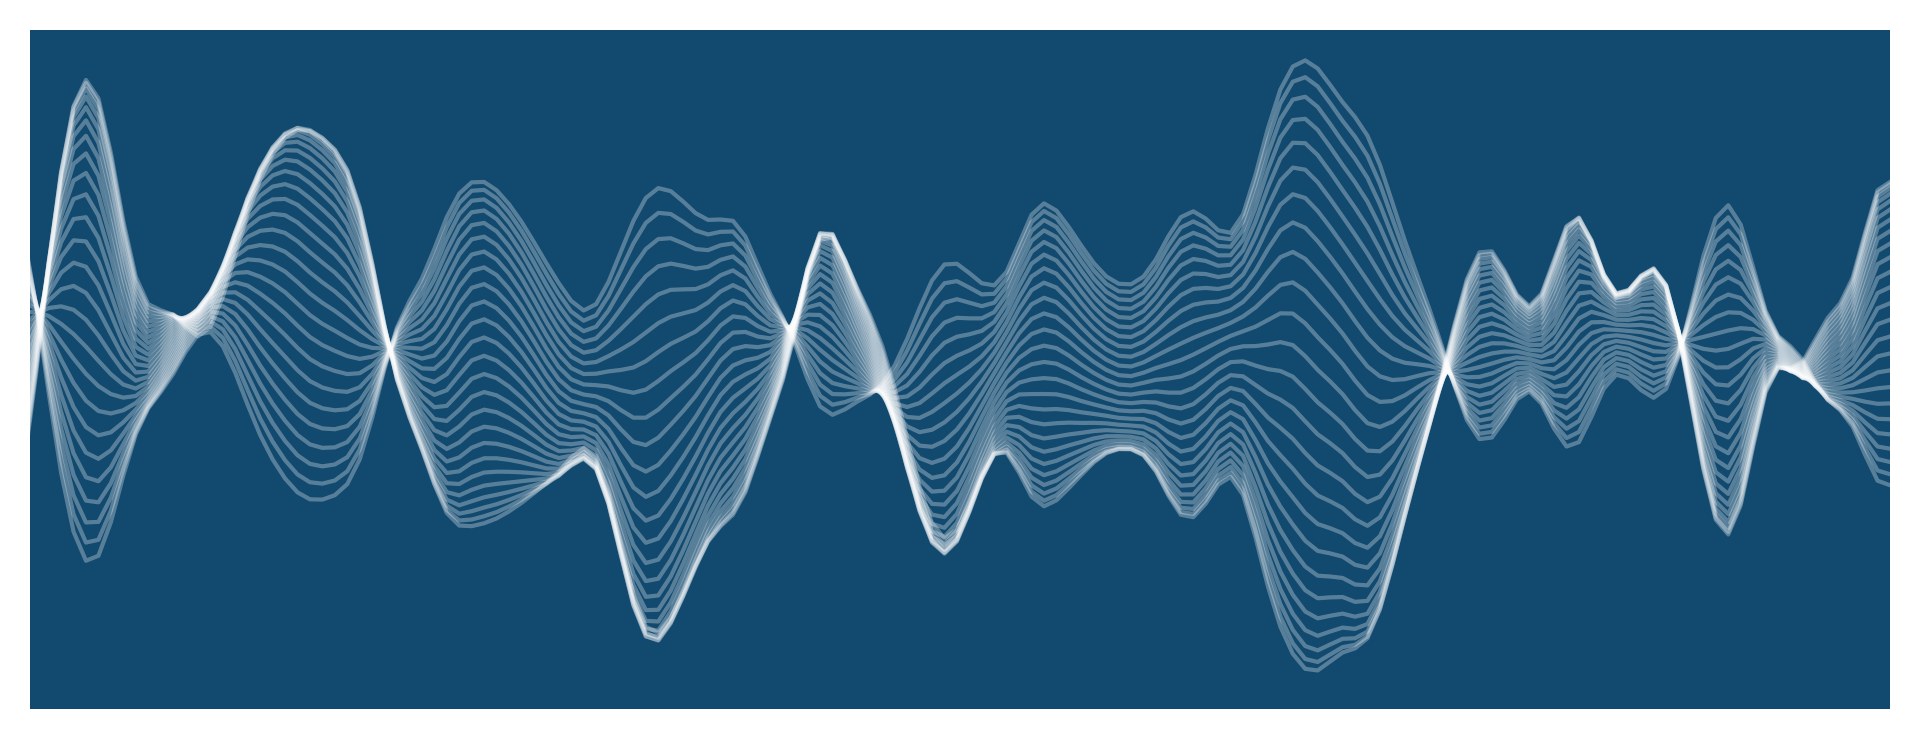

In [65]:
f, ax = plt.subplots(1,1, figsize=(8,3), dpi=300)

ax.plot(x, gp_prior_samples(x, localperiodic, realisations=25, length1=1.5, period=np.pi).T[:,1:], color='w', lw =1, alpha=0.3);
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-0,20]);
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)

In [397]:
samples = gp_prior(x, exp_q, realisations=200, length=3).T

In [398]:
from matplotlib.animation import FuncAnimation

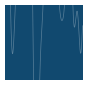

In [401]:
from IPython.display import HTML
fig = plt.figure(dpi=50, figsize=(2,2))
ax = plt.axes(xlim=(-20, 20), ylim=(-5, 5))

ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-20,20]);
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)

x = np.linspace(-20, 20, 1000)

samples = gp_prior_samples(x, exp_q, realisations=1000, alpha = 0.2, length=3).T

line, = ax.plot([], [], lw=1, color='w', alpha=0.3)

def init():
    line.set_data([], [])
    return line,
def animate(i):
    y = samples[:, i]
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=1000, interval=30, blit=True)
HTML(anim.to_html5_video())